In [1]:
#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


#Matplotlib for plotting
import matplotlib.pyplot as plt

#Siphon for finding data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date

#os tools
import os

%matplotlib inline

In [2]:
#UNIDATA thredds location 
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# parse the xml
metar_cat = TDSCatalog(metar_cat_url)

# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)


In [35]:
#Bounding box for our query
bb={'west':-92.5, 'east':-85.0,'north':44, 'south':40.0}

#create a new query for the server
query = ncss.query()

#Pass the bounding box through
query.lonlat_box(**bb)

#what measurements do we want?
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
               'report_id', 'precipitation_amount_hourly', 'precipitation_amount_24')

#restrict to last 1200 hours.. that should be enough data
query.time_range(datetime(2017, 12, 4) - timedelta(hours=144),datetime.utcnow() )
query.accept('csv')

#run the query!
data = ncss.get_data(query)


In [36]:
#Two seperate dictionaries for the data and its locations
station_dict={}
locs ={}

#What variables do we want to extract as data points
want = ('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
       'precipitation_amount_hourly', 'precipitation_amount_24')

#determine the names of the unique stations
stations = np.unique(data['report_id'])

#Loop over each station
for station in stations:
    #identify where in the returned array the station we
    #are interested is.
    wstat = np.where(data['report_id'] == station)
    
    #Grab lat, lon and print and update locs dic
    lat = np.unique(data['latitude'][wstat])
    lon = np.unique(data['longitude'][wstat])
    print(station, lat, lon)
    locs.update({station.decode('UTF-8'): (lat, lon)})
    
    #create a list of python datetime objects from date string
    dates_list = [datetime.strptime(date.decode('UTF-8'), "%Y-%m-%dT%H:%M:%SZ") for date in data['time'][wstat]]
    
    #Create a list of indexes that we can use to sort each station's data by time
    arrrrg = np.array(dates_list).argsort()
    this = {}
    
    #for each variable update the station dictionary with the data
    for key in want:
        this.update({key:data[key][wstat][arrrrg]})
    
    #Add time, time strings and add this station to the master station
    #dictionary
    this.update({'time': np.array(dates_list)[arrrrg]} )
    this.update({'timestr': data['time'][wstat][arrrrg]})
    station_dict.update({station.decode('UTF-8'):this})

b'KAAA' [ 40.159] [-89.33]
b'KAID' [ 40.119] [-85.62]
b'KALO' [ 42.549] [-92.4]
b'KARR' [ 41.77] [-88.47]
b'KASW' [ 41.27] [-85.83]
b'KAWG' [ 41.279] [-91.669]
b'KAZO' [ 42.229] [-85.55]
b'KBEH' [ 42.13] [-86.43]
b'KBIV' [ 42.75] [-86.099]
b'KBMI' [ 40.479] [-88.919]
b'KBRL' [ 40.779] [-91.129]
b'KBTL' [ 42.299] [-85.25]
b'KBUU' [ 42.689] [-88.3]
b'KC09' [ 41.43] [-88.419]
b'KC75' [ 41.02] [-89.389]
b'KCID' [ 41.88] [-91.699]
b'KCMI' [ 40.029] [-88.279]
b'KCMY' [ 43.97] [-90.73]
b'KCWI' [ 41.83] [-90.33]
b'KDBQ' [ 42.4] [-90.699]
b'KDEH' [ 43.279] [-91.73]
b'KDKB' [ 41.93] [-88.72]
b'KDLL' [ 43.52] [-89.769]
b'KDNV' [ 40.2] [-87.599]
b'KDPA' [ 41.919] [-88.25]
b'KDVN' [ 41.61] [-90.569]
b'KEFT' [ 42.61] [-89.589]
b'KEKM' [ 41.72] [-86.]
b'KENW' [ 42.59] [-87.94]
b'KEOK' [ 40.47] [-91.43]
b'KETB' [ 43.419] [-88.129]
b'KFEP' [ 42.25] [-89.58]
b'KFFL' [ 41.049] [-91.98]
b'KFKA' [ 43.68] [-92.18]
b'KFLD' [ 43.77] [-88.489]
b'KFSW' [ 40.669] [-91.33]
b'KFWA' [ 41.] [-85.199]
b'KGBG' [ 40.93

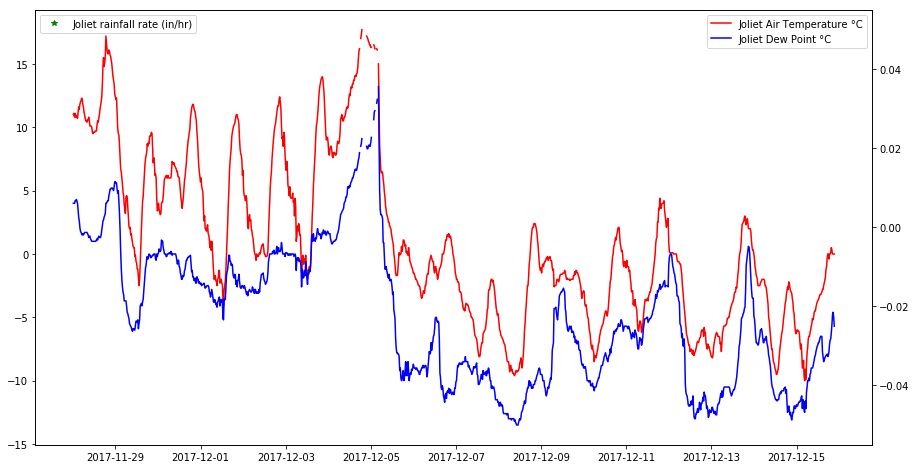

In [37]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['air_temperature'], 
         'r-', label=u'Joliet Air Temperature \u00b0C')
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['dew_point_temperature'], 
         'b-', label=u'Joliet Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['precipitation_amount_hourly'], 'g*',
        label='Joliet rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KLOT.png')

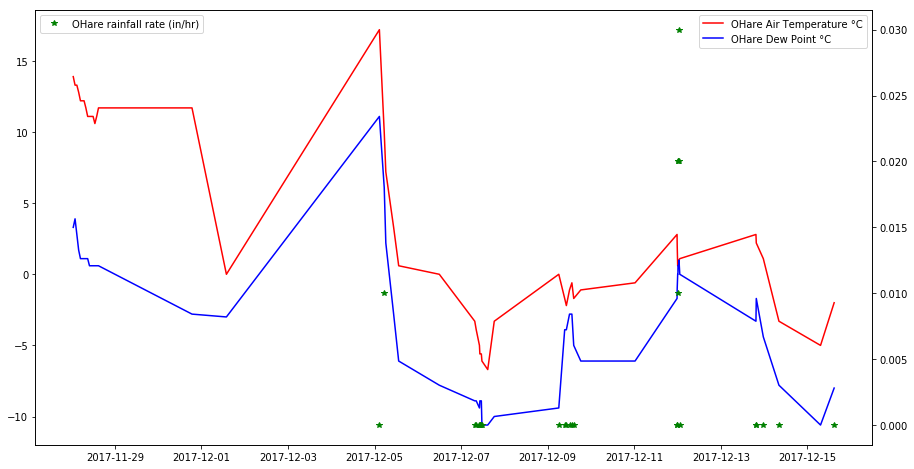

In [38]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['air_temperature'], 
         'r-', label=u'OHare Air Temperature \u00b0C')
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['dew_point_temperature'], 
         'b-', label=u'OHare Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['precipitation_amount_hourly'], 'g*',
        label='OHare rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KORD.png')

In [39]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/projects/precip_change/data/'
headers = ''
for key in list(station_dict[list(station_dict.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in station_dict.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(station_dict[key].keys())
    for i in range(len(station_dict[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(station_dict[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()



KAAA
KAID
KALO
KARR
KASW
KAWG
KAZO
KBEH
KBIV
KBMI
KBRL
KBTL
KBUU
KC09
KC75
KCID
KCMI
KCMY
KCWI
KDBQ
KDEH
KDKB
KDLL
KDNV
KDPA
KDVN
KEFT
KEKM
KENW
KEOK
KETB
KFEP
KFFL
KFKA
KFLD
KFSW
KFWA
KGBG
KGRR
KGSH
KGUS
KGYY
KHAI
KIGQ
KIIB
KIKK
KIOW
KIRS
KJOT
KJVL
KLAF
KLDM
KLNR
KLOT
KLSE
KLWA
KMDW
KMIE
KMKE
KMKG
KMLI
KMPZ
KMQB
KMRJ
KMSN
KMUT
KMWC
KMXO
KOEB
KOKK
KOLZ
KOOA
KORD
KOSH
KOTM
KOVS
KPDC
KPIA
KPNT
KPWK
KRAC
KRFD
KRPJ
KRQB
KRST
KRYV
KSBM
KSBN
KSFY
KSQI
KTIP
KUES
KUGN
KUNU
KVOK
KVPZ
KVTI
KVYS


In [40]:
high_res = {}
for st in station_dict.keys():
    npts = len(station_dict[st]['time'])
    print(st, npts)
    if npts > 100:
        high_res.update({st : station_dict[st]})
        high_res[st].update({'station': [st] * npts})
        high_res[st]['lat'] = list(locs[st][0]) * npts
        high_res[st]['lon'] = list(locs[st][1]) * npts


KAAA 1287
KAID 9
KALO 45
KARR 56
KASW 1124
KAWG 917
KAZO 142
KBEH 292
KBIV 281
KBMI 52
KBRL 44
KBTL 154
KBUU 1287
KC09 1288
KC75 1288
KCID 49
KCMI 43
KCMY 1288
KCWI 68
KDBQ 84
KDEH 848
KDKB 1288
KDLL 1288
KDNV 1174
KDPA 97
KDVN 40
KEFT 1288
KEKM 36
KENW 74
KEOK 917
KETB 1287
KFEP 1148
KFFL 919
KFKA 857
KFLD 122
KFSW 1042
KFWA 109
KGBG 1268
KGRR 136
KGSH 162
KGUS 543
KGYY 368
KHAI 874
KIGQ 1157
KIIB 911
KIKK 1288
KIOW 46
KIRS 872
KJOT 1142
KJVL 526
KLAF 52
KLDM 864
KLNR 419
KLOT 1288
KLSE 102
KLWA 956
KMDW 54
KMIE 127
KMKE 88
KMKG 240
KMLI 54
KMPZ 916
KMQB 1142
KMRJ 1286
KMSN 71
KMUT 918
KMWC 549
KMXO 921
KOEB 865
KOKK 79
KOLZ 919
KOOA 1130
KORD 79
KOSH 124
KOTM 48
KOVS 92
KPDC 1288
KPIA 38
KPNT 1288
KPWK 63
KRAC 92
KRFD 56
KRPJ 1281
KRQB 899
KRST 148
KRYV 1287
KSBM 122
KSBN 143
KSFY 1288
KSQI 49
KTIP 1288
KUES 484
KUGN 102
KUNU 1288
KVOK 476
KVPZ 552
KVTI 851
KVYS 1288


In [41]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/funded_projects/precip_change/data/highres/'
headers = ''
for key in list(high_res[list(high_res.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in high_res.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(high_res[key].keys())
    for i in range(len(high_res[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(high_res[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()

KAAA
KASW
KAWG
KAZO
KBEH
KBIV
KBTL
KBUU
KC09
KC75
KCMY
KDEH
KDKB
KDLL
KDNV
KEFT
KEOK
KETB
KFEP
KFFL
KFKA
KFLD
KFSW
KFWA
KGBG
KGRR
KGSH
KGUS
KGYY
KHAI
KIGQ
KIIB
KIKK
KIRS
KJOT
KJVL
KLDM
KLNR
KLOT
KLSE
KLWA
KMIE
KMKG
KMPZ
KMQB
KMRJ
KMUT
KMWC
KMXO
KOEB
KOLZ
KOOA
KOSH
KPDC
KPNT
KRPJ
KRQB
KRST
KRYV
KSBM
KSBN
KSFY
KTIP
KUES
KUGN
KUNU
KVOK
KVPZ
KVTI
KVYS


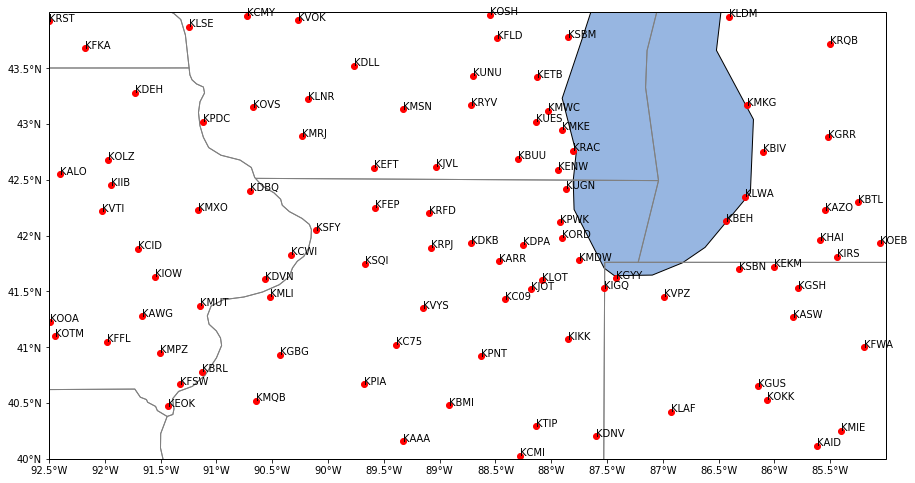

In [42]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(locs.keys()):
    ax.plot(locs[station_name][1], locs[station_name][0], 'ro')
    ax.text(locs[station_name][1], locs[station_name][0], station_name)
plt.savefig('../images/locations_midwest.png')

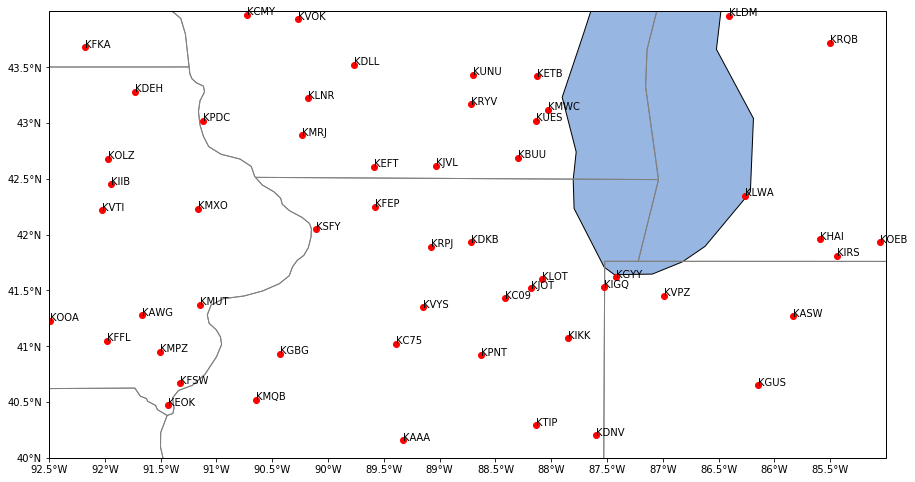

In [51]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(high_res.keys()):
    ax.plot(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], 'ro')
    ax.text(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], station_name)
plt.savefig('../images/locations_midwest_highres.png')